In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from scipy import stats
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

Contando cuantos elementos hay en el dataset *iris*

In [49]:
# Cargar el dataset IRIS
df = pd.read_csv('resources/iris.csv')
df_clean = df.dropna()
print(len(df))
print(df.head())

150
   sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa


Eliminación de valores atípicos

In [50]:
# Seleccionar solo las columnas numéricas
numeric_cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

# Calcular IQR
Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

# Filtrar filas sin outliers
df_clean = df[~((df[numeric_cols] < (Q1 - 1.5 * IQR)) | 
                (df[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

print(f"Filas originales: {len(df)}, Filas después de limpieza: {len(df_clean)}")

Filas originales: 150, Filas después de limpieza: 146


Estandarizar variables independientes

In [51]:
# Estandarizar (media=0, desviación=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean[numeric_cols])
X_scaled = pd.DataFrame(X_scaled, columns=numeric_cols)

# Verificar
print(X_scaled.mean(), X_scaled.std(), sep="\n")

sepal_length    7.300097e-16
sepal_width    -7.300097e-17
petal_length    9.733462e-17
petal_width    -3.406712e-16
dtype: float64
sepal_length    1.003442
sepal_width     1.003442
petal_length    1.003442
petal_width     1.003442
dtype: float64


# Analisis de normalidad

A) Shapiro-wilk

In [52]:
for col in numeric_cols:
    stat, p = stats.shapiro(X_scaled[col])
    print(f"{col}: p-valor = {p:.4f} (Normalidad {'aceptada' if p > 0.05 else 'rechazada'})")

sepal_length: p-valor = 0.0142 (Normalidad rechazada)
sepal_width: p-valor = 0.0607 (Normalidad aceptada)
petal_length: p-valor = 0.0000 (Normalidad rechazada)
petal_width: p-valor = 0.0000 (Normalidad rechazada)


B) QQ-plots

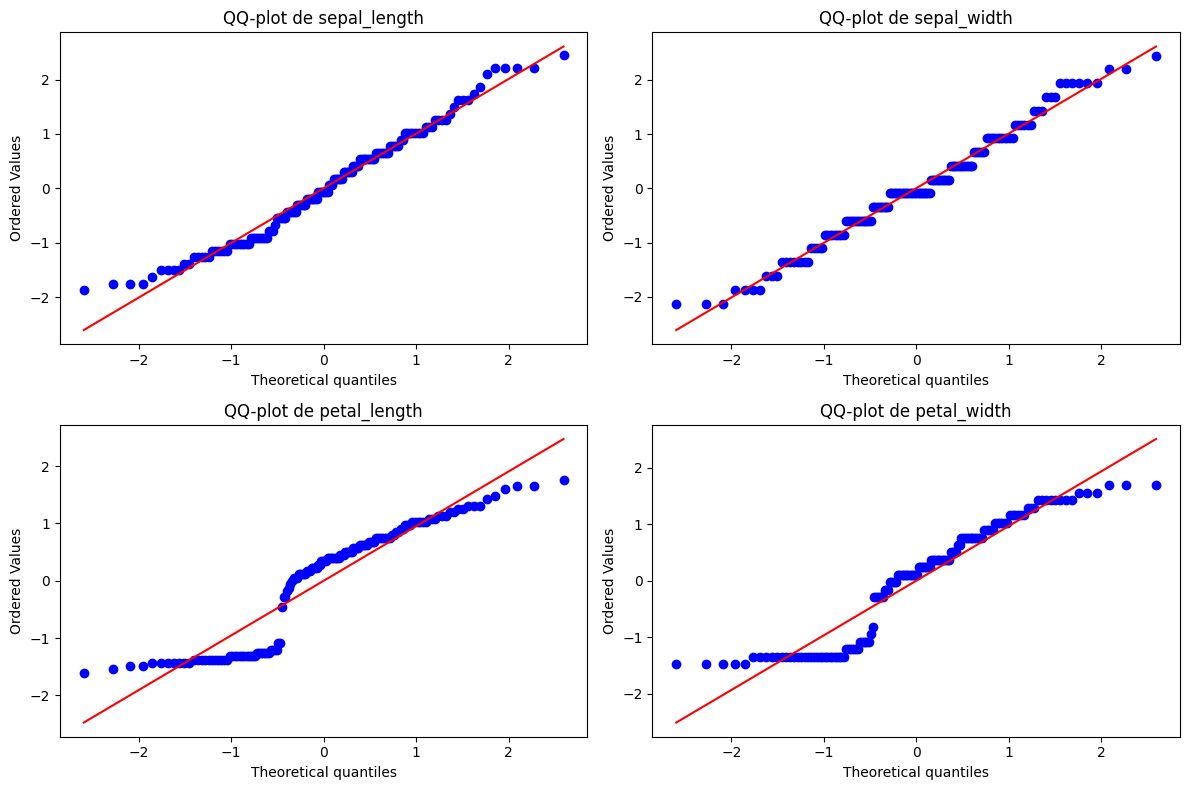

In [53]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i, col in enumerate(numeric_cols):
    stats.probplot(X_scaled[col], plot=axes[i//2, i%2])
    axes[i//2, i%2].set_title(f"QQ-plot de {col}")
plt.tight_layout()
plt.show()

# 5. Análisis de multicoleanidad

a) Matriz de correlación

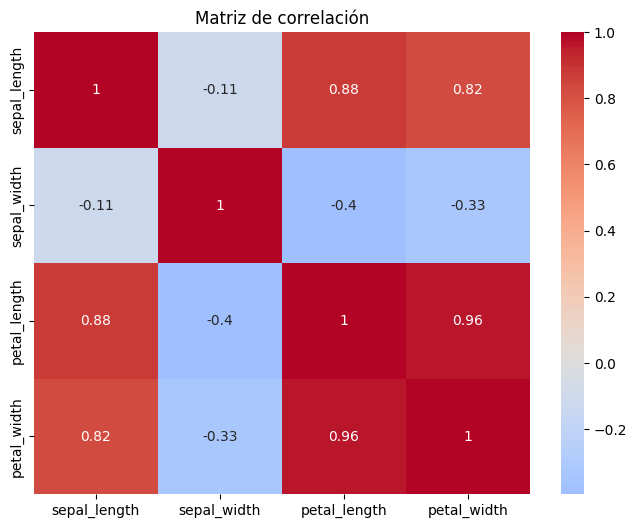

In [54]:
plt.figure(figsize=(8, 6))
sns.heatmap(X_scaled.corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Matriz de correlación")
plt.show()

b) Factor de Inflación de Varianza (VIF):

In [55]:
vif_data = pd.DataFrame()
vif_data["Variable"] = numeric_cols
vif_data["VIF"] = [variance_inflation_factor(X_scaled.values, i) for i in range(len(numeric_cols))]
print(vif_data)

       Variable        VIF
0  sepal_length   7.083561
1   sepal_width   1.929409
2  petal_length  30.859423
3   petal_width  15.884308


# 4. Implemente en Python los siguientes modelos:

**4.1 Aplicación de PCA y reducción a 2 componentes principales.**

In [56]:
from sklearn.decomposition import PCA

# Aplicar PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Crear DataFrame con los componentes
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['species'] = df_clean['species'].values  # Añadir columna de especies

# Varianza explicada
print("Varianza explicada por cada componente:", pca.explained_variance_ratio_)
print("Varianza total explicada (2 componentes):", sum(pca.explained_variance_ratio_))

Varianza explicada por cada componente: [0.72600625 0.23072944]
Varianza total explicada (2 componentes): 0.956735686213838


**4.2 Visualización de la proyección de los datos en el nuevo espacio PCA.**

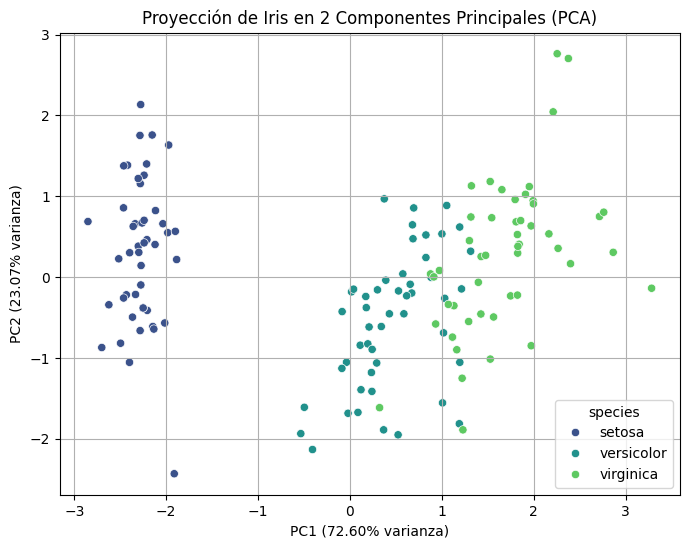

In [57]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='species', palette='viridis')
plt.title("Proyección de Iris en 2 Componentes Principales (PCA)")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%} varianza)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%} varianza)")
plt.grid()
plt.show()

**4.3 Aplicación de LDA y reducción a 2 componentes discriminantes.**

In [58]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Aplicar LDA
lda = LDA(n_components=2)
X_lda = lda.fit_transform(X_scaled, df_clean['species'])  # LDA requiere etiquetas (y)

# Crear DataFrame con los componentes
df_lda = pd.DataFrame(X_lda, columns=['LD1', 'LD2'])
df_lda['species'] = df_clean['species']

# Porcentaje de separación entre clases
print("Varianza explicada por cada componente discriminante:", lda.explained_variance_ratio_)

Varianza explicada por cada componente discriminante: [0.99193167 0.00806833]


**4.4 Visualización de la proyección de los datos en el nuevo espacio LDA.**

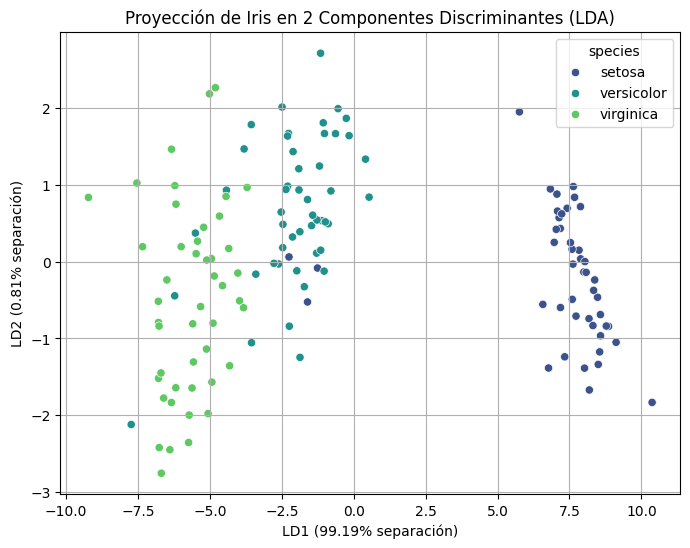

In [59]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_lda, x='LD1', y='LD2', hue='species', palette='viridis')
plt.title("Proyección de Iris en 2 Componentes Discriminantes (LDA)")
plt.xlabel(f"LD1 ({lda.explained_variance_ratio_[0]:.2%} separación)")
plt.ylabel(f"LD2 ({lda.explained_variance_ratio_[1]:.2%} separación)")
plt.grid()
plt.show()

# 5) Entrene un modelo de regresión logística en el espacio proyectado por PCA y LDA. Compare el rendimiento del modelo en ambos casos

**5.1 Precisión**

In [64]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize

# Dividir datos en entrenamiento y prueba (70% train, 30% test)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    df_pca[['PC1', 'PC2']], df_pca['species'], test_size=0.3, random_state=42
)

X_train_lda, X_test_lda, y_train_lda, y_test_lda = train_test_split(
    df_lda[['LD1', 'LD2']], df_lda['species'], test_size=0.3, random_state=42
)

In [61]:
# Entrenar modelos
model_pca = LogisticRegression(max_iter=200)
model_pca.fit(X_train_pca, y_train_pca)

model_lda = LogisticRegression(max_iter=200)
model_lda.fit(X_train_lda, y_train_lda)

# Predecir y evaluar
y_pred_pca = model_pca.predict(X_test_pca)
y_pred_lda = model_lda.predict(X_test_lda)

ValueError: Input contains NaN

In [ ]:
# 1. Precisión
accuracy_pca = accuracy_score(y_test_pca, y_pred_pca)
accuracy_lda = accuracy_score(y_test_lda, y_pred_lda)
print(f"Precisión PCA: {accuracy_pca:.4f}")
print(f"Precisión LDA: {accuracy_lda:.4f}")